# Introduction
***
Notebook **#2-ensemble_modelling_daun_singkong_eksperimen_4** mengimplementasikan sesuai tahapan sesuai skenario 4 pada notes di drive: <br>
- Melakukan feature selection dari inputan data baru yang dihasilkan kelima model classifier dengan 5-fold cross-validation sebelum masuk ke tahapan klasifikasi dengan ANN

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# visualization purpose
import matplotlib.pyplot as plt

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from collinearity import SelectNonCollinear
from sklearn.decomposition import PCA

# utils
import pickle

#
from models.model_ensembles import EnsembleStacking

# Load Data After Preprocessing

In [2]:
dataset_daun_singkong_after_preprocessing = pickle.load(open('../dataset/data_daun_singkong_after_preprocessing.pkl', 'rb'))
X_train = dataset_daun_singkong_after_preprocessing['training']['X']
y_train = dataset_daun_singkong_after_preprocessing['training']['y']
X_test = dataset_daun_singkong_after_preprocessing['testing']['X']
y_test = dataset_daun_singkong_after_preprocessing['testing']['y']

In [3]:
# sampling data
# X_train = X_train[:1000]
# X_test = X_test[:1000]
# y_train = y_train[:1000]
# y_test = y_train[:1000]

# Defining Global Variables 

In [4]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for MLP
max_iter=400 
batch_size=32 
verbose=0
n_iter_no_change=20

# Defining Global Functions

In [5]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            all_sub_model_name = list()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)
                all_sub_model_name.append(sub_model_name)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            df_results_for_each_classifiers = pd.DataFrame(all_predicted_results[model_name])
            df_results_for_each_classifiers.columns = [model_name+"_"+sub_model_name for sub_model_name in all_sub_model_name]
            list_of_majority_voting_each_models.append(df_results_for_each_classifiers)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

# Modelling

## Create Stacking ML Ensemble from 5-fold cross-validation

In [6]:
ensemble_classifiers = EnsembleStacking(X_train, y_train, X_test, y_test, kfold).train_ensemble()

In [7]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results = list()
for model in ensemble_classifiers.keys():
    ensemble_classifiers_results.append(pd.DataFrame(ensemble_classifiers[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results = pd.concat(ensemble_classifiers_results, axis=0)

In [8]:
ensemble_classifiers_results

,train,training,validation,testing
model-5,SVC(),0.625939,0.622371,0.625389
model-4,SVC(),0.626022,0.624374,0.625078
model-3,SVC(),0.625104,0.622705,0.624455
model-1,SVC(),0.624238,0.622497,0.623209
model-2,SVC(),0.623237,0.624499,0.622897
model-4,LogisticRegression(solver='newton-cg'),0.625438,0.626377,0.625545
model-3,LogisticRegression(solver='newton-cg'),0.625772,0.62571,0.624766
model-5,LogisticRegression(solver='newton-cg'),0.626273,0.624708,0.624455
model-1,LogisticRegression(solver='newton-cg'),0.626826,0.623164,0.623832
model-2,LogisticRegression(solver='newton-cg'),0.624405,0.626502,0.623832


## Create new input Training from the stacking ensemble ML

In [9]:
new_input_training_features = create_new_input_features(
    ensemble_classifiers, 
    X_train,
    y_train
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [10]:
new_input_training_features

,svm_model-1,svm_model-2,svm_model-3,svm_model-4,svm_model-5,logreg_model-1,logreg_model-2,logreg_model-3,logreg_model-4,logreg_model-5,...,naive_bayes_model-2,naive_bayes_model-3,naive_bayes_model-4,naive_bayes_model-5,decision_tree_model-1,decision_tree_model-2,decision_tree_model-3,decision_tree_model-4,decision_tree_model-5,ground_truth
0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,4,3,4,4,4,4
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,1,1,1,1,1,1
2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,2,1,1,1,1,1
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,4,1,4,4,4,4
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14972,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,1,3,3,3
14973,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
14974,3,3,3,3,3,4,4,4,4,4,...,3,3,3,3,1,1,1,3,1,1
14975,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


## Feature selection from new input features

In [11]:
X_new_input_features = new_input_training_features.drop(['ground_truth'], axis=1)
y_new_input_features = new_input_training_features['ground_truth'].copy()

In [12]:
X_new_input_features.shape

(14977, 20)

### Feature Selection using ChiSquare

#### Calculate feature importance for all feature

In [13]:
fs_chi_square = SelectKBest(score_func=chi2, k='all')
fs_chi_square.fit(X_new_input_features, y_new_input_features)
X_train_fs_chi_square = fs_chi_square.transform(X_new_input_features)

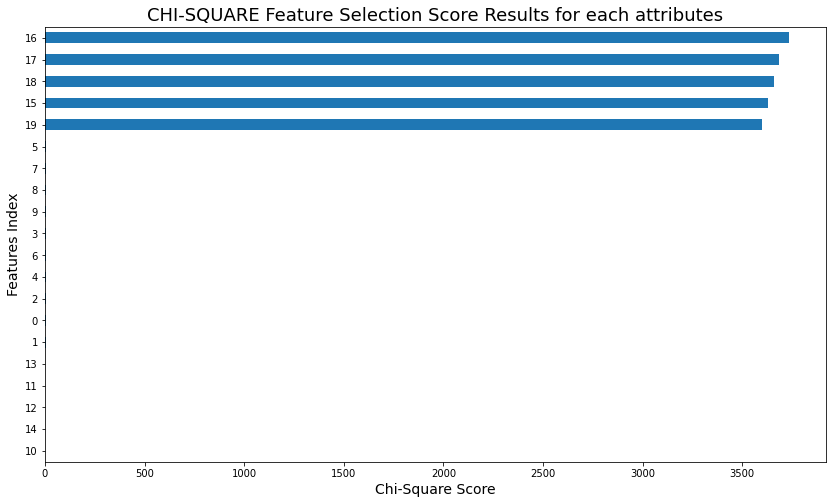

In [14]:
chi2_series = pd.Series(fs_chi_square.scores_).sort_values(ascending=True)
plt.figure(figsize=(14,8))
plt.title('CHI-SQUARE Feature Selection Score Results for each attributes', size=18)
chi2_series.plot(kind='barh')
plt.ylabel('Features Index', size=14)
plt.xlabel('Chi-Square Score', size=14)
plt.show()

#### Select top best feature

In [15]:
# select for 4 top features
fs_chi_square = SelectKBest(score_func=chi2, k=4)
fs_chi_square.fit(X_new_input_features, y_new_input_features)
X_train_fs_chi_square = fs_chi_square.transform(X_new_input_features)

In [16]:
X_train_fs_chi_square

array([[4, 3, 4, 4],
       [1, 1, 1, 1],
       [2, 1, 1, 1],
       ...,
       [1, 1, 1, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3]], dtype=int64)

#### Feed Selected New Input Features into ANN

In [17]:
# split X and y from new_input_features before feeding to ANN
new_X_train_chi_square = X_train_fs_chi_square
new_y_train_chi_square = y_new_input_features.copy()

# feed new X and new y into ANN
ann_model_fs_chi_square = MLPClassifier(max_iter=max_iter, batch_size=batch_size, verbose=verbose, n_iter_no_change=n_iter_no_change)
ann_model_fs_chi_square.fit(new_X_train_chi_square, new_y_train_chi_square)

predicted_ann_train_chi_square = ann_model_fs_chi_square.predict(new_X_train_chi_square)

# print final results classification
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Data = ", accuracy_score(new_y_train_chi_square, predicted_ann_train_chi_square))

Final Accuracy Score [Mls Ensembles + ANN] on Training Data =  1.0


### Feature Reduction using Principal Component Analysis

In [18]:
# Fit training data into PCA calculation
pca_model = PCA()
pca_model.fit(X_new_input_features)

pca_component_results = pd.DataFrame({
    'Komponen ke-': [i+1 for i in range(0,X_new_input_features.shape[1])],
    'Variance': pca_model.explained_variance_,
    'Proporsi Variance': pca_model.explained_variance_ratio_,
    'Kumulatif Proporsi Variance': pca_model.explained_variance_ratio_.cumsum()
})

In [19]:
pca_component_results

,Komponen ke-,Variance,Proporsi Variance,Kumulatif Proporsi Variance
0,1,3.437432e+00,5.990890e-01,0.599089
1,2,6.472779e-01,1.128101e-01,0.711899
2,3,3.765285e-01,6.562284e-02,0.777522
3,4,3.684749e-01,6.421924e-02,0.841741
4,5,3.644256e-01,6.351350e-02,0.905255
5,6,3.515086e-01,6.126228e-02,0.966517
6,7,1.172230e-01,2.043007e-02,0.986947
7,8,1.930681e-02,3.364866e-03,0.990312
8,9,1.268257e-02,2.210367e-03,0.992522
9,10,9.079000e-03,1.582323e-03,0.994105


In [20]:
threshold_cumsum = 0.97
best_pca_component = pca_component_results[
    pca_component_results['Kumulatif Proporsi Variance']>=threshold_cumsum
].index[0]+1
print('Best Principal Component using = ', best_pca_component)

Best Principal Component using =  7


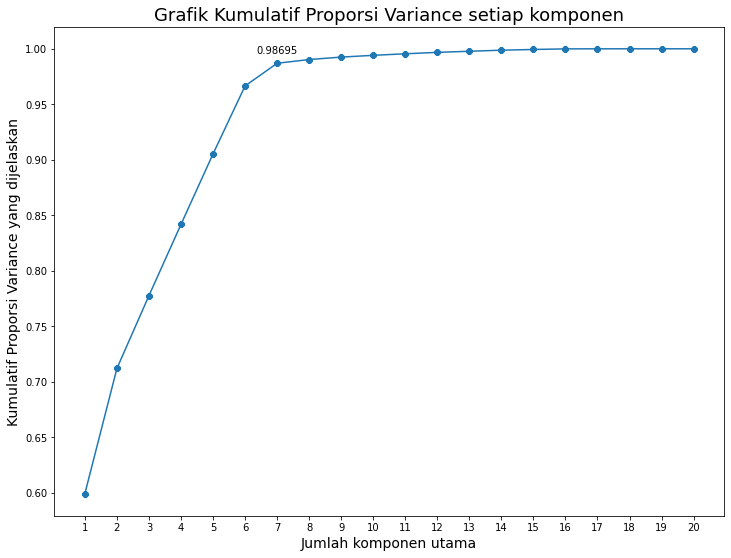

In [21]:
cumsum_component_explained = pca_model.explained_variance_ratio_.cumsum()
customs_labels = [i+1 for i in range(0,X_new_input_features.shape[1])]
string_label = best_pca_component
xs = range(0,X_new_input_features.shape[1])

plt.figure(figsize=(12,9))
pd.Series(cumsum_component_explained).plot(marker="8")
plt.xticks(ticks=xs, labels=customs_labels)
plt.title('Grafik Kumulatif Proporsi Variance setiap komponen', size=18)
plt.xlabel('Jumlah komponen utama', size=14)
plt.ylabel('Kumulatif Proporsi Variance yang dijelaskan',size=14)

label_index = customs_labels.index(best_pca_component)
xs_index = xs[label_index]
text = round(pca_component_results[
    pca_component_results['Kumulatif Proporsi Variance']>=threshold_cumsum
].iloc[0]['Kumulatif Proporsi Variance'],5)
plt.annotate(
    text, 
    (xs_index,text),
    textcoords="offset points",
    xytext=(0,10),
    ha='center'
)

plt.show()

#### Select top best principal component

In [22]:
pca_scaler = PCA(n_components=best_pca_component)
pca_scaler.fit(X_new_input_features)
X_train_pca = pca_scaler.transform(X_new_input_features)

#### Feed Selected New Input Features into ANN

In [23]:
# split X and y from new_input_features before feeding to ANN
new_X_train_pca = X_train_pca
new_y_train_pca = y_new_input_features

# feed new X and new y into ANN
ann_model_pca = MLPClassifier(max_iter=max_iter, batch_size=batch_size, verbose=verbose, n_iter_no_change=n_iter_no_change)
ann_model_pca.fit(new_X_train_pca, new_y_train_pca)

predicted_ann_train_pca = ann_model_pca.predict(new_X_train_pca)

# print final results classification
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Data = ", accuracy_score(new_y_train_pca, predicted_ann_train_pca))

Final Accuracy Score [Mls Ensembles + ANN] on Training Data =  1.0


# Save Stacking Model Pretrained (MLs + ANN)

In [24]:
model_ensemble_experiment_4 = {
    'stacking_ensembles': ensemble_classifiers,
    'new_input_feature_selection': {
        'chi-square': {
            'predictor': fs_chi_square,
            'ann': ann_model_fs_chi_square
        },
        'pca': {
            'predictor': pca_scaler,
            'ann': ann_model_pca
        }
    },
    'data': {
        'training': {
            'X': X_train,
            'y': y_train
        },
        'testing': {
            'X': X_test,
            'y': y_test
        }
    }
}
pickle.dump(model_ensemble_experiment_4, open("model_ensemble_experiment_results/model_ensemble_eksperimen_4.pkl", 'wb'))